# 走神司机检测 PyTorch实现
本项目的数据来源是kaggle走神司机项目的[数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)。该数据集包含了10种类别的司机驾驶中的行为。为了简化处理，本项目已经将所有的数据下载并解压到跟本文件同目录，之后的所有操作建立在如下目录结构基础上：<br>
├── distracted_driver_detection.ipynb<br>
├── driver_imgs_list.csv<br>
└── imgs<br>
 &emsp;&emsp;├──testroot <br>
 &emsp;&emsp; &emsp;&emsp;├── test[79726 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp;└──train [22423 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c0 [2489 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c1 [2267 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c2 [2317 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c3 [2346 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c4 [2326 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c5 [2312 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c6 [2325 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c7 [2002 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c8 [1911 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;└── c9 [2129 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
├── cache [.h5 files] <br>
└── subm [.csv file]<br>

In [47]:
from __future__ import print_function
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
import cv2
import matplotlib.pyplot as plt
import os
import glob
import time
import shutil
import copy
import seaborn as sea
from sklearn.cross_validation import KFold
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 数据探索

In [2]:
# 读取csv
driver_image_lists = pd.read_csv('driver_imgs_list.csv')
driver_image_lists.tail()

,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [3]:
# 标签数组
classnames = list(set(driver_image_lists['classname']))
classnames.sort()
classnames

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

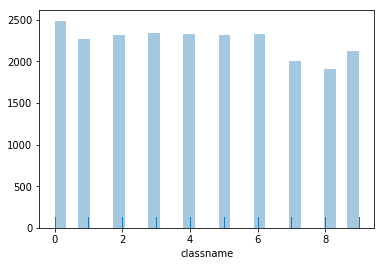

In [5]:
# 图片类别分布
classname_transfer = driver_image_lists['classname'].str[1:].astype('float32')
sea.distplot(classname_transfer,kde=False,rug=True)

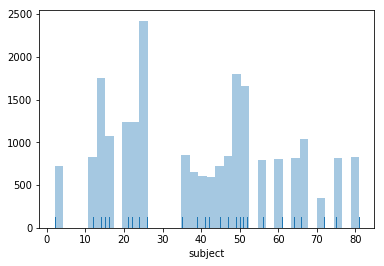

In [6]:
# 司机类别分布
subject_transfer = driver_image_lists['subject'].str[1:].astype('float32')
sea.distplot(subject_transfer,kde=False,rug=True)

In [4]:
# 根据unique_dirvers在driver_image_lists找到对应的img列表，
# 示例为{'subject1':['img1.jpg','img2.jpg','img3.jpg']}
def get_driver_img_map(driver_image_lists):
    # 司机id的集合
    unique_dirvers = list(set(driver_image_lists['subject']))
    driver_img_dict = {}
    for driver_id in unique_dirvers:
        img_list = driver_image_lists[driver_image_lists['subject']==driver_id]['img'].values.tolist()
        if driver_id in driver_img_dict:
            driver_img_dict[driver_id].extend(img_list)
        else:
            driver_img_dict[driver_id] = img_list
    return unique_dirvers,driver_img_dict

## 样本可视化

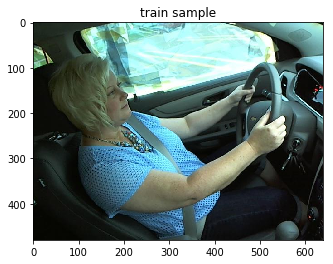

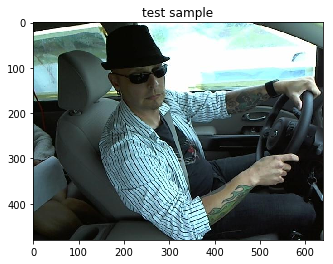

In [5]:
# 在训练集和测试集中分别选取一张图片进行展示
def show_sample(): 
    train_image_path = os.path.join('../imgs','train','c0','*.jpg')
    test_image_path = os.path.join('../imgs','testroot','test','*.jpg')
    train_files = glob.glob(train_image_path)
    test_files = glob.glob(test_image_path)
    train_file_index = 0
    test_file_index = 0
    for fl in train_files:
        if train_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('train sample')
            plt.show()
            break
    for fl in test_files:
        if test_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('test sample')
            plt.show()
            break
show_sample()

## 全局变量

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_image_dir = os.path.join('../imgs','train')
test_image_dir = os.path.join('../imgs','testroot')
model_dir = os.path.join('bestmodels')
unique_driver_ids,driver_img_dict = get_driver_img_map(driver_image_lists)
use_cuda = torch.cuda.is_available()

## 超参数

In [88]:
DROPOUT_PROB = 0.5
N_EPOCHS = 20
BATCH_SIZE = 1
LR = 0.001
PIN_MEMORY=use_cuda # True IF CUDA

## 预处理与数据增强

In [8]:
transform_normal = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_aug = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## 自定义数据集
因为有交叉验证的需要，所以需要自定义数据集。

In [9]:
class SplitTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, split_img_list, tSet=False):
        self.img_path = img_path
        classnames = list(set(driver_image_lists['classname']))
        classnames.sort()
        self.class_names = classnames
        self.split_img_list = split_img_list
        self.tSet = tSet
        super(SplitTrainingDataset, self).__init__()
    
    def __len__(self):
        return len(self.split_img_list)
        
    def __getitem__(self, i):
        img_name = self.split_img_list[i]
        class_name = driver_image_lists[driver_image_lists['img']==img_name]['classname'].values[0]
        path = os.path.join(self.img_path,class_name,img_name)
        img = Image.open(path).convert('RGB')
        if self.tSet:
            self.transform = transform_aug
        else:
            self.transform = transform_normal
        img = self.transform(img)
        label = self.class_names.index(class_name)
        return img,label


## 中间数据处理

In [72]:
# 创建缓存文件夹
def make_cache_dir():
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    if not os.path.isdir('subm'):
        os.mkdir('subm')

# 缓存数据
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

#　恢复数据
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

# 返回K组预测平均值
def predict_mean(data,nfolds):
    first_fold = np.array(data[0])
    for i in range(1,nfolds):
        first_fold += np.array(data[i])
    first_fold /= nfolds
    return first_fold.tolist()

def append_chunk(main,part):
    for p in part:
        main.append(p)
    return main

# 创建提交文件
def create_submission(predictions,testid_list,filename,submit_file_path='subm'):
    # 为了避免极端值，进行数据裁剪
    predictions = predictions.clip(min=1e-15,max=(1-1e-15))
    df = pd.DataFrame(np.array(predictions),columns=['c'+str(i) for i in range(10)])
    df.insert(0,'img',testid_list)
    path = os.path.join(submit_file_path,filename)
    df.to_csv(path,index=None)
    print('Create submit file finished')

## Finetuning 模型

In [15]:
# 如何要从头训练整个网络，可以考虑这种方法，加载预训练模型的话有些麻烦
# model_ft = models.vgg13_bn(pretrained=False,num_classes=10)

In [42]:
# 参考vgg源码自定义的模型
class Mymodel(nn.Module):
    def __init__(self, basemodel, modelname,num_classes=10):
        super(Mymodel, self).__init__()
        self.features = basemodel.features
        self.classifier = basemodel.classifier
        self.classifier[-1] = nn.Linear(4096, num_classes)
        self.modelname = modelname
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

## 模型训练

In [73]:
def train_model(model, modelname, datasize_t, datasize_v, trainloader, validloader, criterion, optimizer, scheduler, num_fold, num_epochs):
    since = time.time()
    best_loss = float("inf")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*20)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            is_train = True
            if phase == 'train':
                scheduler.step()
                model.train()    # Set model to trainning mode
            else:
                is_train = False
                model.eval()    # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            if is_train:
                # 训练集数据用于训练模型，并统计训练误差
                for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = label.to(device)
                
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        _,preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                    
                    # 统计本批次的训练误差和正确率
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                # 利用累计误差和准确率得出整个训练集的平均误差  
                epoch_loss = running_loss / datasize_t
                epoch_acc = running_corrects.double() / datasize_t
                
                print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
            else:
                # 验证集只验证模型的误差和准确率
                for inputs, labels in validloader:
                    inputs = inputs.to(device)
                    labels = label.to(device)
                
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _,preds = torch.max(outputs, 1)
                        loss = criterion(outpus, labels)
                    
                    # 统计本批次的验证误差和正确率
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                # 利用累计误差和准确率得出整个验证集的平均误差    
                epoch_loss = running_loss / datasize_t
                epoch_acc = running_corrects.double() / datasize_t
                print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
                if epoch_acc > best_acc:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_loss = epoch_loss
                    
        
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        # load best model weights
        model.load_state_dict(best_model_wts)
        # 如果交叉验证的话，这里就不是返回该模型，而是保存该模型
        torch.save(model.stat_dict(), os.path.join(model_dir, modelname+'_'+str(num_fold)+'.pth'))
        return best_loss

## 模型集成

In [58]:
# 自定义Dataset的方式进行交叉验证，由于num_worker不能大于0，所以可能会非常慢，具体原因待查
def kfold_split_and_train(basemodel, modelname ,unique_dirver_ids, driver_img_dict, img_path, k=10, num_epochs=N_EPOCHS):
    loss_scores = []
    kf = KFold(len(unique_dirver_ids), n_folds=k, shuffle=True, random_state=51)
    num_fold = 0
    for train_driver_ids, valid_driver_ids in kf:
        num_fold += 1
        # 根据id在driver_image_lists中找对应的文件名
        train_img_name_list = []
        valid_img_name_list = []
        
        for index in train_driver_ids:
            train_img_name_list.extend(driver_img_dict[unique_driver_ids[index]])
        for index in valid_driver_ids:
            valid_img_name_list.extend(driver_img_dict[unique_driver_ids[index]])
            
        train_dataset = SplitTrainingDataset(img_path, train_img_name_list, True)
        valid_dataset = SplitTrainingDataset(img_path, valid_img_name_list)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=4)
        # 控制学习的范围，先从只训练全连接层开始，如果数据量更大，或者训练精度的需要，可以逐层放开前层
        for param in basemodel.parameters():
            param.requires_grad = False
        basemodel.classifier[-1] = nn.Linear(4096, 10)
        basemodel = basemodel.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(basemodel.classifier.parameters(), lr=LR)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        # 训练并保存最优模型
        loss = train_model(basemodel,
                    modelname,
                    len(train_img_name_list),
                    len(valid_img_name_list),
                    train_loader,
                    valid_loader,
                    criterion,
                    optimizer,
                    scheduler,
                    num_fold,
                    num_epochs
                    )
        loss_scores.append(loss)
        # 先训练一个分类器
        if num_fold == 1:
            break
    return loss_scores

In [69]:
# 笨办法，将某些司机的数据拷贝至train_*文件夹，其余司机的数据拷贝至val_*文件夹，然后直接用ImageFolder读取
def kfold_split_copy_data(unique_dirver_ids, img_path, k=10):
    kf = KFold(len(unique_dirver_ids), n_folds=k, shuffle=True, random_state=51)
    num_fold = 1
    for train_driver_ids, valid_driver_ids in kf:
        print('Start copy image on fold: ' + str(num_fold))
        # 根据id在driver_image_lists中找对应的文件名
        train_img_name_list = []
        valid_img_name_list = []
        for id in train_driver_ids:
            train_img_name_list.extend(driver_img_dict[id])
        for id in valid_driver_ids:
            valid_img_name_list.extend(driver_img_dict[id])
            
        print('Start copy train image on fold: ' + str(num_fold))
        for img_name in train_img_name_list:
            class_name = driver_image_lists[driver_image_lists['img']==img_name]['classname'].values[0]
            src_path = os.path.join(self.img_path,class_name,img_name)
            dst_path = os.path.join('train'+str(num_fold),class_name,img_name)
            shutil.copy(src_path, dst_path)
        print('Finish copy train image on fold: {}, image location: train{}'.format(num_fold, num_fold))
        
        print('Start copy valid image on fold: '+ str(num_fold))
        for img_name in valid_img_name_list:
            class_name = driver_image_lists[driver_image_lists['img']==img_name]['classname'].values[0]
            src_path = os.path.join(self.img_path,class_name,img_name)
            dst_path = os.path.join('valid'+str(num_fold),class_name,img_name)
            shutil.copy(src_path, dst_path)
        print('Finish copy valid image on fold: {}, image location: valid{}'.format(num_fold, num_fold))
        
        num_fold += 1
        print('Finish copy image on fold: ' + str(num_fold))

In [61]:
vgg13bn = models.vgg13_bn(pretrained=True)
vgg13_loss_scores = kfold_split_and_train(vgg13bn, 'vgg13bn', unique_driver_ids, driver_img_dict, train_image_dir)

Epoch 0/19
--------------------


OSError: [Errno 12] Cannot allocate memory

### 模型预测

In [89]:
test_dataset = datasets.ImageFolder(test_image_dir, transform_normal)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [77]:
def kfold_test(basemodel, modelname, trained_model, k=10):
    predictions = []
    for num_fold in range(10):
        num_fold += 1
        prediction = []
        # Load trained weight
        basemodel.load_state_dict(os.path.join(model_dir, modelname+'_'+str(num_fold)+'.pth'))
        test_prediction_cache_path = os.path.join('cache','test_prediction_'+modelname+'_'+str(num_fold)+'.h5')
        for data in test_loader:
            image,_ = data
            outputs = basemodel(image)
            predicttion = append_chunk(prediction, outputs)
        cache_data(prediction, test_prediction_cache_path)
        predictions.append(prediction)
        
        if num_fold == 1:
            break
    return predictions

In [90]:
model = models.vgg13_bn(pretrained=True)
model.classifier[-1] = nn.Linear(4096,10)
for index,data in enumerate(test_loader):
    image,_ = data
    outputs = model(image)
    print(outputs)
    if index==0:
        break

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:204